<a href="https://colab.research.google.com/github/alessioborgi/DL_Project/blob/main/Source/InfoRetrievalDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install -q --upgrade pip
# it takes quite a lot
!pip install -q pyserini==0.12.0
# !pip install -q pyserini==0.21.0
# !pip install -q faiss-gpu
!pip install -q pytorch-lightning transformers datasets torch wandb

!git clone https://github.com/alessioborgi/DL_Project.git

In [2]:
# base
import json
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from collections import Counter
from typing import List, Tuple
from tqdm import tqdm
from enum import Enum

# for pyserini stuffs
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

# cool plots
import wandb

# torch
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

# lightning
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor, StochasticWeightAveraging, DeviceStatsMonitor, ModelPruning

# HF and similar
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from transformers import AutoModel, AutoTokenizer, AutoTokenizer, AutoModelForSequenceClassification, T5Tokenizer, T5ForConditionalGeneration, EncoderDecoderCache, pipeline

# sklearn
from sklearn.preprocessing import normalize
from sklearn.cluster import AgglomerativeClustering, KMeans

# pyserini
from pyserini.index import IndexReader
from pyserini.search import SimpleSearcher

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, RegexpTokenizer

# data augmentation
import inflect

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 1: DOWNLOADING MSMARCO (100k)




In [ ]:
# loading MS MARCO splits
ms_marco_train = load_dataset("microsoft/ms_marco", "v1.1", split="train")
ms_marco_validation = load_dataset("microsoft/ms_marco", "v1.1", split="validation")
ms_marco_test = load_dataset("microsoft/ms_marco", "v1.1", split="test")

## 1.1 RETRIEVE TOP 1000 DOCUMENTS

In [ ]:
searcher = SimpleSearcher.from_prebuilt_index('msmarco-passage')

In [ ]:
def create_datasets(base_dataset, K=1000):
    list_of_docids = []

    for i in tqdm(range(len(base_dataset))):
        sample = base_dataset[i]
        query = sample['query']
        hits = searcher.search(query, K)

        # retrieve top 1000 docids
        # 1000 docids in a single string separated by a space
        list_of_docids.append((sample['query_id'], ' '.join([h.docid for h in hits])))
    return list_of_docids

In [ ]:
train_ranked_documents = create_datasets(ms_marco_train)
valid_ranked_documents = create_datasets(ms_marco_validation)
test_ranked_documents = create_datasets(ms_marco_test)

  2%|▏         | 230/10047 [00:34<33:29,  4.88it/s]

## 1.2: SAVING RANKED DOCUMENTS

In [ ]:
def save_docids_list(docids_list, split):
    file_name = f"{split}_ranked_docids.json"
    # save locally
    with open(file_name, "w") as fp:
        json.dump(docids_list, fp)
    # copy to gdrive
    !cp {file_name} '/content/drive/MyDrive/deep-learning-files/'

In [ ]:
save_docids_list(train_ranked_documents, "train")
save_docids_list(valid_ranked_documents, "valid")
save_docids_list(test_ranked_documents, "test")

## 1.3: READING RANKED DOCUMENTS

In [ ]:
def read_list(split):
    with open(f"/content/drive/MyDrive/deep-learning-files/{split}_ranked_docids.json", 'rb') as fp:
        return json.load(fp)

In [ ]:
train_ranked_documents = read_list("train")
valid_ranked_documents = read_list("valid")
test_ranked_documents = read_list("test")

## 1.4: BUILDING DATASET WITH RANKED DOCIDS

In [ ]:
ms_marco_train = ms_marco_train.map(lambda example, idx: {"ranked_docids": train_ranked_documents[idx][1]}, with_indices=True)
ms_marco_validation = ms_marco_validation.map(lambda example, idx: {"ranked_docids": valid_ranked_documents[idx][1]}, with_indices=True)
ms_marco_test = ms_marco_test.map(lambda example, idx: {"ranked_docids": test_ranked_documents[idx][1]}, with_indices=True)

# 2: DATASET EXPLORATION

In [ ]:
# Function to print dataset characteristics.
def print_dataset_info(name, dataset):
    print(f"\nDataset: {name}")
    print("-" * 40)
    print(f"Number of samples: {len(dataset)}")
    print(f"Features: {dataset.features.keys()}")
    print("\nExample:")
    for k in dataset.features.keys():
        print('\t', f'{k}: ', dataset[0][k])
        if(k == 'passages'):
            print('\t\t', "Number of passages:", len(dataset[0][k]['passage_text']))
            for i in range(len(dataset[0][k]['passage_text'])):
                print('\t\t', f'Passage {i}: ', dataset[0][k]['passage_text'][i])
    print('\n\n')

# print information for each split.
print_dataset_info("Train", ms_marco_train)
print_dataset_info("Validation", ms_marco_validation)
print_dataset_info("Test", ms_marco_test)


Dataset: Train
----------------------------------------
Number of samples: 82326
Features: dict_keys(['answers', 'passages', 'query', 'query_id', 'query_type', 'wellFormedAnswers'])

Example:
	 answers:  ['Results-Based Accountability is a disciplined way of thinking and taking action that communities can use to improve the lives of children, youth, families, adults and the community as a whole.']
	 passages:  {'is_selected': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0], 'passage_text': ["Since 2007, the RBA's outstanding reputation has been affected by the 'Securency' or NPA scandal. These RBA subsidiaries were involved in bribing overseas officials so that Australia might win lucrative note-printing contracts. The assets of the bank include the gold and foreign exchange reserves of Australia, which is estimated to have a net worth of A$101 billion. Nearly 94% of the RBA's employees work at its headquarters in Sydney, New South Wales and at the Business Resumption Site.", "The Reserve Bank of Aust

In [ ]:
# Analyze specific features.
def analyze_passages(dataset):
    print("\n--- Passage Analysis ---")
    passage_lengths = [len(p["passage_text"][0]) for p in dataset["passages"]]
    print(f"Number of passages per query: {len(dataset[0]['passages']['passage_text'])}")
    print(f"Average passage length: {sum(passage_lengths) / len(passage_lengths):.2f} characters")
    print(f"Max passage length: {max(passage_lengths)} characters")
    print(f"Min passage length: {min(passage_lengths)} characters")

# Analyze passages in the train set.
analyze_passages(ms_marco_train)


--- Passage Analysis ---
Number of passages per query: 10
Average passage length: 414.24 characters
Max passage length: 1167 characters
Min passage length: 43 characters


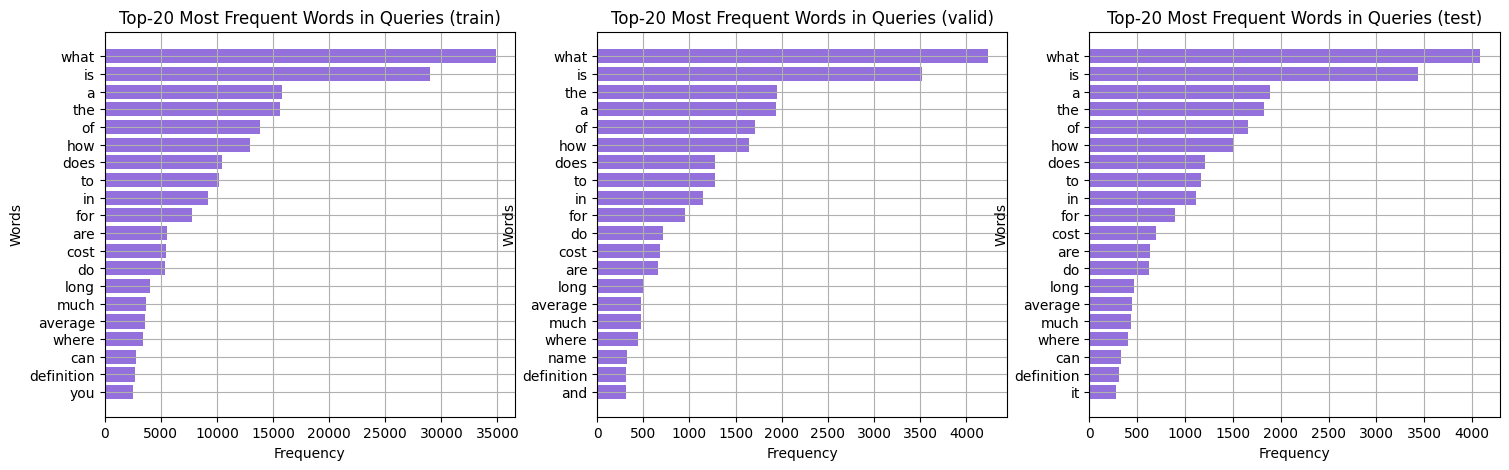

In [ ]:
def plot_top_words(datasets, top_n=20):
    """
        Function used to plot the top words in queries and passages. Since all passages are composed by a different numbers of texts, an average of them is taken.

        > datasets: set of all the partitions used
        > top_n: number of most frequent words
    """
    fig, axes = plt.subplots(nrows=1, ncols=len(datasets.keys()), figsize=(18, 5))

    for i, split_name in enumerate(datasets.keys()):
        ax = axes[i]
        dataset = datasets[split_name]
        lowercase_queries = [x.lower() for x in dataset["query"]]
        all_queries = " ".join(lowercase_queries)
        word_counts = Counter(all_queries.split())
        most_common_words = word_counts.most_common(top_n)

        words, counts = zip(*most_common_words)
        ax.barh(words, counts, color="mediumpurple")
        ax.invert_yaxis()
        ax.set_title(f"Top-{top_n} Most Frequent Words in Queries ({split_name})")
        ax.set_xlabel("Frequency")
        ax.set_ylabel("Words")
        ax.grid(True)

    plt.show()

plot_top_words({"train": ms_marco_train, "valid": ms_marco_validation, "test": ms_marco_test})

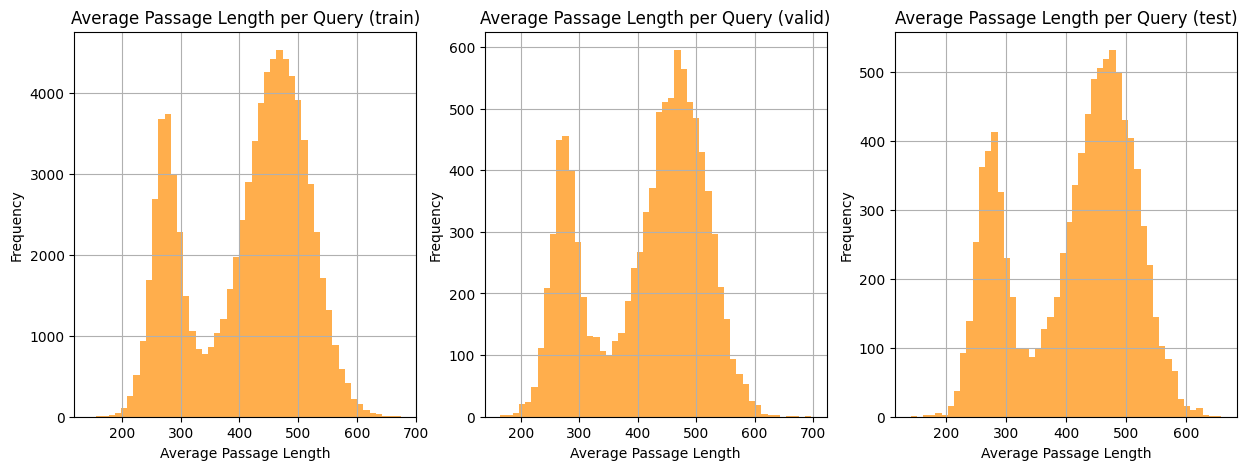

In [ ]:
def analyze_passages_per_query(dataset_dict):
    fig, axes = plt.subplots(nrows=1, ncols=len(dataset_dict.keys()), figsize=(15, 5))

    for i, split_name in enumerate(dataset_dict.keys()):
        ax = axes[i]
        dataset = dataset_dict[split_name]

        avg_lengths = [np.mean([len(passage) for passage in p["passage_text"]]) for p in dataset["passages"]]
        ax.hist(avg_lengths, bins=50, alpha=0.7, color="darkorange")
        ax.set_title(f"Average Passage Length per Query ({split_name})")
        ax.set_xlabel("Average Passage Length")
        ax.set_ylabel("Frequency")
        ax.grid(True)

    plt.show()

analyze_passages_per_query({"train": ms_marco_train, "valid": ms_marco_validation, "test": ms_marco_test})

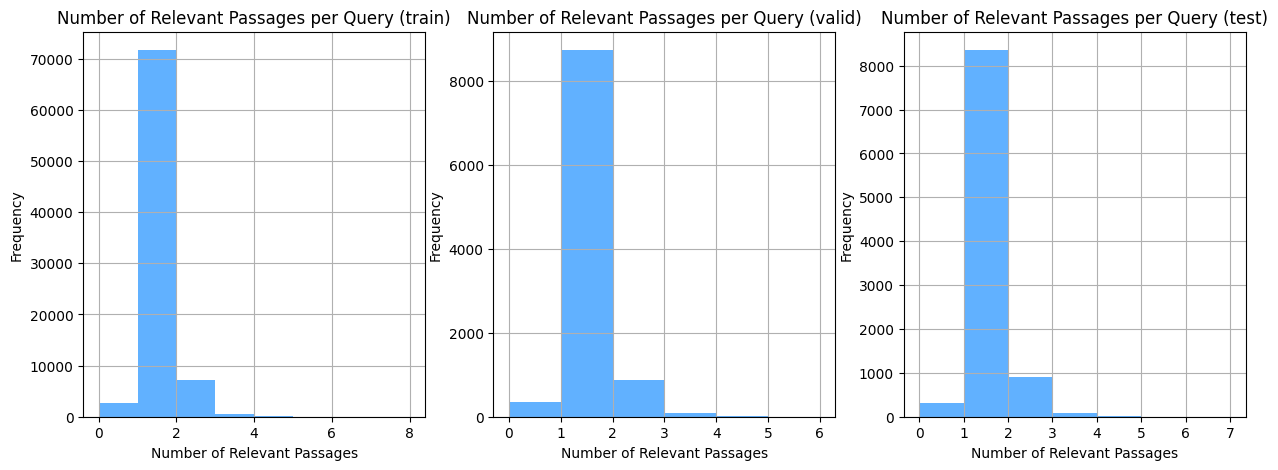

In [ ]:
def analyze_relevance_distribution(dataset_dict):
    fig, axes = plt.subplots(nrows=1, ncols=len(dataset_dict.keys()), figsize=(15, 5))

    for i, split_name in enumerate(dataset_dict.keys()):
        ax = axes[i]
        dataset = dataset_dict[split_name]

        relevant_counts = [sum(p["is_selected"]) for p in dataset["passages"]]
        ax.hist(relevant_counts, bins=range(0, max(relevant_counts) + 2), alpha=0.7, color="dodgerblue")
        ax.set_title(f"Number of Relevant Passages per Query ({split_name})")
        ax.set_xlabel("Number of Relevant Passages")
        ax.set_ylabel("Frequency")
        ax.grid(True)

    plt.show()

analyze_relevance_distribution({"train": ms_marco_train, "valid": ms_marco_validation, "test": ms_marco_test})

# 3: DSI-Multi GENERATION

The core idea is that the model must create associations between `queries` and `docids`.

<h2>What do we have to do?</h2>

As the (second) paper mention, we need to construct a dataset $\mathcal{T}'$.\
To do so, we start from the generation of $$\mathcal{U} = \mathcal{O} \cup \mathcal{P}\qquad
\begin{cases}
\mathcal{O} = \bigcup_i \mathcal{O}_i = \bigcup_i \{d^1_i, d^2_i, \dots, d^m_i\}\\[10pt]
\mathcal{P} = \bigcup_i \mathcal{P}_i = \bigcup_i \{pq^1_i, pq^2_i, \dots, pq^m_i\}
\end{cases}$$
with
*   $d_i^j$ the $j$-th segment of the $i$-th document that belongs to the set $\mathcal{D}$ and
*   $pq_i^j$ the pseudo-query generated by [docT5query](https://github.com/castorini/docTTTTTquery) against the document segment $d_i^j$

then, having such computed $\mathcal{U}$, we need to filter it using a so called *'dense model'* named $M$. Due to its nature, dense retrieval models effectively preserve textual information in its representation (i.e. in its latent space), so they are perfect to address such task.

> We need to find a dense retrieval model open-source



<h2>How to filter?</h2>

We need to input individual fragment $t$ originating from the document of $id_t$ that belongs to $U$ in our dense retrieval model $M$; so our $t$ now behaves like a query
$$t\in d_t = doc(id_t)\in U$$
this process outputs a ranked list of $k$ elements
$$R_k(t, M) = (id^1, id^2,\dots, id^k)$$
if $id_t$ belongs to $R_k(t, M)$ this means that *'the fragment $t$ possessed keyinformation relevant to the original document'* and so can be included in the training corpus $T'$.\
In other words, in this way we asses that $t$ har enough information to represent the document identified by $id_t$ ans so it is a suitable query.

We'll proceed by steps, applying the real preprocessing we mentioned earlied on the vanilla dataset created; hence, in order:

1.   semantically structured docids as explained in the original paper (i.e. using KMeans)
2.   pseudo-query generation using [docT5query](https://github.com/castorini/docTTTTTquery)
3.   tokenization of document' segments using the sentence encoder [all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2)




## 3.1: SEMANTICALLY STRUCTURED DOCIDS CREATION




In [ ]:
def generate_semantic_ids(document_embeddings, n_clusters = 10, max_docs_per_cluster = 100, depth = 0):
    n_docs, _ = document_embeddings.shape
    cluster_prefix = []

    # base case, whether we have a cluster with at most
    # 'c' documents, we return their index in current cluster
    if n_docs <= max_docs_per_cluster:
        # return [f"{depth}-{i}" for i in range(n_docs)]
        return [f"{i}" for i in range(n_docs)]

    # k-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(document_embeddings)

    cluster_labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    # generate docids for each cluster
    structured_ids = []
    for cluster_id in range(n_clusters):
        # mask for documents of the current centroid
        cluster_indices = np.where(cluster_labels == cluster_id)[0]
        cluster_embeddings = document_embeddings[cluster_indices]

        # doids for the sub-cluster
        sub_ids = generate_semantic_ids(cluster_embeddings, n_clusters, max_docs_per_cluster, depth + 1)

        # cluster_prefix = [f"{depth}-{cluster_id}"] * len(sub_ids)
        cluster_prefix = [f"{cluster_id}"] * len(sub_ids)

        # combine parent prefix with sub-cluster identifiers
        # structured_ids.extend([f"{prefix}-{sub_id}" for prefix, sub_id in zip(cluster_prefix, sub_ids)])
        structured_ids.extend([f"{prefix}{sub_id}" for prefix, sub_id in zip(cluster_prefix, sub_ids)])

    return structured_ids

In [ ]:
def generate_semantically_structured_docids(dataset, sentence_embedder, n_clusters=10, max_docs_per_cluster=10, start_from=0, stop_at=100):
    document_corpus = []
    document_embeddings = []

    # iterate within the range start_from to stop_at
    for i in range(start_from, min(len(dataset), stop_at + 1)):
        if i % 10 == 0: print("Processing document: ", i)

        # retrieve all passages in a document
        passages = dataset[i]['passages']['passage_text']

        # add the entire corpus of a document
        document_corpus.append(' '.join(passages))

        # compute embeddings for each passage
        passages_embeddings = sentence_embedder.encode(passages)

        # average passages embeddings to maintain semantic meaning
        document_embedding = np.mean(passages_embeddings, axis=0)

        # append one document embedding
        document_embeddings.append(document_embedding)

    ssdocids = generate_semantic_ids(np.array(document_embeddings), n_clusters=n_clusters, max_docs_per_cluster=max_docs_per_cluster)

    return document_embeddings, document_corpus, ssdocids

In [ ]:
sentence_embedder = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
start_from = 0
stop_at = 100

document_embeddings, document_corpus, ssdocids = generate_semantically_structured_docids(
    ms_marco_train, sentence_embedder, n_clusters=10, max_docs_per_cluster=10, start_from=start_from, stop_at=stop_at)

# output_file = f"semantically_structured_docids_train_{start_from}_{stop_at}.json"

# with open(output_file, "w") as f:
#     json.dump(ssdocids, f, indent=4)

# print(f"Semantically structured document IDs saved to {output_file}")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Processing document:  0
Processing document:  10
Processing document:  20
Processing document:  30
Processing document:  40
Processing document:  50
Processing document:  60
Processing document:  70
Processing document:  80
Processing document:  90
Processing document:  100


## 3.2: DOCUMENT SPLITTING AND PSEUDO QUERIES (DATASETS $O$ AND $P$)

In [ ]:
tokenizer = T5Tokenizer.from_pretrained('castorini/doc2query-t5-base-msmarco')
model = T5ForConditionalGeneration.from_pretrained('castorini/doc2query-t5-base-msmarco').to(device)

tokenizer_config.json:   0%|          | 0.00/1.89k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

In [ ]:
def generate_pseudo_queries(dataset, tokenizer, retrieval_model, max_pseudo_query_len=64, top_k=1, start_from=0, stop_at=100, debug=False):
    pseudo_queries = [] # P
    passages = [] # O

    for i in range(start_from, min(len(dataset), stop_at + 1)):
        if i % 10 == 0: print("Processing document: ", i)

        l = len(dataset[i]['passages']['passage_text'])

        for j in range(l):

            t = dataset[i]['passages']['passage_text'][j]
            passages.append(t)

            # tokenize the segment (i.e. the passage)
            input_ids = tokenizer.encode(t, return_tensors='pt').to(device)

            # doct5query predict top k(=1) queries
            outputs = model.generate(
                input_ids=input_ids,
                max_length=max_pseudo_query_len,
                do_sample=True,
                top_k=top_k,
                num_return_sequences=1
            ).to(device)

            # decode the (pseudo-)query
            decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)

            if debug:
                print(f'SAMPLE {j + 1}: \n passage: {t}\n pseudo-query: {decoded}')
                print('-'*50)

            pseudo_queries.append({'document_index': i, "pseudo-query": decoded})

    return passages, pseudo_queries

In [ ]:
top_k = 1
max_pseudo_query_len = 64
start_from = 0
stop_at = 100
debug = False

passages, pseudo_queries = generate_pseudo_queries(ms_marco_train, tokenizer, model, max_pseudo_query_len, top_k, start_from, stop_at, debug)

Processing document:  0
Processing document:  10
Processing document:  20
Processing document:  30
Processing document:  40
Processing document:  50
Processing document:  60
Processing document:  70
Processing document:  80
Processing document:  90
Processing document:  100


In [ ]:
output_file = f"pseudo_query_train_{start_from}_{stop_at}.json"

with open(output_file, "w") as f:
    json.dump(ssdocids, f, indent=4)

print(f"Pseudo Query saved to {output_file}")

## 3.3 GENERATE DATASET $U$

In [ ]:
sentence_embedder = SentenceTransformer('all-MiniLM-L6-v2')

tokenizer = T5Tokenizer.from_pretrained('castorini/doc2query-t5-base-msmarco')
model = T5ForConditionalGeneration.from_pretrained('castorini/doc2query-t5-base-msmarco').to(device)

start_from = 0
stop_at = 100

max_pseudo_query_lenght = 64
top_k = 1

In [ ]:
# embeddings and docids for each document
document_embeddings, document_corpus, ssdocids = generate_semantically_structured_docids(
    ms_marco_train,
    sentence_embedder,
    n_clusters = 10,
    max_docs_per_cluster = 10,
    start_from = start_from,
    stop_at = stop_at)

# pseudo_queries for each sentence
passages, pseudo_queries = generate_pseudo_queries(
    ms_marco_train,
    tokenizer = tokenizer,
    retrieval_model = model,
    max_pseudo_query_len = max_pseudo_query_lenght,
    top_k = top_k,
    start_from = start_from,
    stop_at = stop_at,
    debug=False)

In [ ]:
len(pseudo_queries), len(ssdocids)

(823, 101)

$$\mathcal{U}= \mathcal{O}\cup \mathcal{P}$$

In [ ]:
def generate_samples_to_rank(dataset, ssdocids, pseudo_queries, start_from=0, stop_at=100):
    resulting_dataset = []

    for i in range(start_from, min(len(dataset), stop_at + 1)):
        l = len(dataset[i]['passages']['passage_text'])

        docid = ssdocids[i]

        for j in range(l):
            resulting_dataset.append({
                'doc_id': docid,
                'doc_segment': dataset[i]['passages']['passage_text'][j],
                'segment_pseudo_query': pseudo_queries[j]['pseudo-query']})

    return resulting_dataset

In [ ]:
start_from = 0
stop_at = 100

U = generate_samples_to_rank(ms_marco_train, ssdocids, pseudo_queries, start_from, stop_at)

In [ ]:
with open("U.json", "w") as f:
    json.dump(U, f, indent=4)

## 3.4: FILTERING: RETRIEVAL MODELS FOR RANKING

We are going to use the MSMARCO-100k, so we'll apply each of these stuffs on it.

1.   For the pseudo-queries generation, we can use the [docT5query](https://github.com/castorini/docTTTTTquery) from castorini
2.   As a *'dense retrieval model'* for ranking documents we can use the one proposed by castorini: [FAISS](https://github.com/castorini/pyserini/blob/master/docs/usage-search.md#faiss)
3.   For the segments extraction we can rely on a manually crafted approach

In order to better check the improvements lead from a dense retrieval model w.r.t. a sparse one, we'll use an approach based also on Lucene (a sparse retrieval model) and an hybrid one, combining both FAISS and Lucene.


The hybrid retrieval pipeline we propose combines **dense retrieval** (using FAISS) and **sparse retrieval** (using Lucene with BM25). The objective of this step is to rank documents based on both semantic similarity and lexical matching to achieve robust results.

---
As a first, step, we need to use a `SentenceTransformer` model to encode documents into dense vector embeddings, which are then indexed by FAISS.

- For a document $d_i$, the embedding is represented as:
  $$
  \mathbf{e}_{d_i} = f_{\text{dense}}(d_i)
  $$
  where $f_{\text{dense}}$ is the embedding function provided by the `SentenceTransformer` model.

- The embeddings of all documents are stored in a matrix:
  $$
  \mathbf{E} = [\mathbf{e}_{d_1}, \mathbf{e}_{d_2}, \dots, \mathbf{e}_{d_N}] \in \mathbb{R}^{N \times D}
  $$
  Here, $N$ is the number of documents, and $D$ is the embedding dimensionality.

Similarly, the query $q$ is encoded into a dense vector:
$$
\mathbf{e}_q = f_{\text{dense}}(q)
$$

Assuming we have a temporary dataset consisting of `(doc_id, doc_segment, segment_pseudo_query)`\
I'll sketch a pseudocode (since we need to build such temporary dataset)

In [ ]:
def build_dataset_with_ranker(dataset, rank, index, sentence_embedder, top_k=1):
    final_dataset = []

    for elem in dataset:
        doc_id = elem['doc_id']
        t = elem['doc_segment']
        pq = elem['segment_pseudo_query']

        # lucene
        if sentence_embedder is None:
            distances, indices = rank(t, index, top_k=top_k)
        # faiss
        else:
            query_embedding = sentence_embedder.encode([t], convert_to_numpy=True)
            distances, indices = rank(query_embedding, index, top_k=top_k)

        if doc_id in ssdocids[indices.squeeze()]:
            final_dataset.append({
                'docid': doc_id,
                'segment': t,
                'pseudo-query': pq,
                'ranker_distance': distances[0]
            })

    return final_dataset

### 3.4.1: FAISS DENSE RETRIEVAL MODEL






- **Index Creation**: The normalized document embeddings are added to a FAISS `IndexFlatIP` index.
- **Querying**: Given the query embedding $\mathbf{e}_q$, FAISS retrieves the top-$k$ documents based on inner product:
$$
\text{score}_{\text{FAISS}}(q, d_i) = \mathbf{e}_q \cdot \mathbf{e}_{d_i}
$$

The FAISS search returns:
- `indices`: The IDs of the top-$k$ documents.
- `distances`: The corresponding similarity scores.

<h3> NORMALIZATION FOR COSINE SIMILARITY </h3>

FAISS uses **inner product** for similarity scoring by default. To ensure the scores are equivalent to cosine similarity, we apply a simple trick consisting in making both the document embeddings and the query embedding to be normalized:
$$
\mathbf{e}' = \frac{\mathbf{e}}{\|\mathbf{e}\|}
$$
Where $\|\mathbf{e}\|$ is the L2 norm of the embedding.

Normalized embeddings allow the inner product to behave like cosine similarity:
$$
\text{cosine_similarity}(\mathbf{e}_q, \mathbf{e}_{d_i}) = \mathbf{e}_q \cdot \mathbf{e}_{d_i}
$$

In [ ]:
document_embeddings = np.array(document_embeddings)

# latent (embedding) dim
dim = document_embeddings.shape[1]

# based on cosine similarity (IP = Inner Product)
faiss_index = faiss.IndexFlatIP(dim)

# normalize and add document embeddings to FAISS index
faiss.normalize_L2(document_embeddings)
faiss_index.add(document_embeddings)

In [ ]:
def ranker_faiss(query_embedding, faiss_index, top_k=1):
    faiss.normalize_L2(query_embedding)

    # Perform FAISS search
    faiss_distances, faiss_indices = faiss_index.search(query_embedding, top_k)

    return faiss_distances, faiss_indices

In [ ]:
faiss_dataset = build_dataset_with_ranker(U, ranker_faiss, faiss_index, sentence_embedder)

In [ ]:
faiss_dataset[0]

{'docid': '00',
 'segment': "Since 2007, the RBA's outstanding reputation has been affected by the 'Securency' or NPA scandal. These RBA subsidiaries were involved in bribing overseas officials so that Australia might win lucrative note-printing contracts. The assets of the bank include the gold and foreign exchange reserves of Australia, which is estimated to have a net worth of A$101 billion. Nearly 94% of the RBA's employees work at its headquarters in Sydney, New South Wales and at the Business Resumption Site.",
 'pseudo-query': "what is the rba's assets",
 'ranker_distance': array([0.7115933], dtype=float32)}

### 3.4.2: LUCENE SPARSE RETRIEVAL MODEL


Lucene uses the **BM25** algorithm for sparse retrieval. For a query $q$ and document $d_i$, the BM25 relevance score is given by:
$$
\text{BM25}(q, d_i) = \sum_{t \in q} \text{IDF}(t) \cdot \frac{f(t, d_i) \cdot (k_1 + 1)}{f(t, d_i) + k_1 \cdot (1 - b + b \cdot \frac{|d_i|}{\text{avgdl}})}
$$
Where:
- $t$: A term in the query.
- $f(t, d_i)$: The frequency of term $t$ in document $d_i$.
- $|d_i|$: The length of the document.
- $\text{avgdl}$: The average document length in the corpus.
- $k_1$: Controls term frequency saturation (default $1.2$).
- $b$: Controls length normalization (default $0.75$).
- $\text{IDF}(t)$: The inverse document frequency of term $t$:
  $$
  \text{IDF}(t) = \log\left(\frac{N - n_t + 0.5}{n_t + 0.5} + 1\right)
  $$
  Where $N$ is the total number of documents and $n_t$ is the number of documents containing term $t$.




Pyserini retrieves the top-$k$ documents using BM25 scoring. The results include:
- `docid`: Document IDs.
- `BM25_score`: BM25 relevance scores.



In [ ]:
jsonl_path = "documents.jsonl"
index_path = "lucene-index"

# pairs (doc_id, doc_text) written into a JSONL file
with open(jsonl_path, "w") as f:
    for doc_id, content in zip(ssdocids, document_corpus):
        f.write(json.dumps({"id": doc_id, "contents": content}) + "\n")

# clear previous index (if any)
os.system(f"rm -rf {index_path}")

# build lucene index
os.system(f"python -m pyserini.index -collection JsonCollection "
          f"-generator DefaultLuceneDocumentGenerator "
          f"-threads 1 -input . -index {index_path} -storeRaw")

# rank segments
lucene_index = LuceneSearcher(index_path)
lucene_index.set_bm25(k1=0.9, b=0.4)

In [ ]:
def ranker_lucene(pseudo_query, lucene_index, top_k=1):
    lucene_hits = lucene_index.search(pseudo_query, k=top_k)

    lucene_distances = []
    lucene_indices = []

    for rank, hit in enumerate(lucene_hits):
        lucene_indices.append(hit.docid)
        lucene_distances.append(hit.score)

    return lucene_distances, lucene_indices

In [ ]:
lucene_dataset = build_dataset_with_ranker(U, ranker_lucene, lucene_index, sentence_embedder)

### 3.4.3: HYBRID RETRIEVAL MODEL


To leverage the strengths of both retrieval approaches, we combine the scores from FAISS and Lucene.

The combined score for each document is calculated through a **Linear Score Fusion**, i.e., as a weighted sum:
$$
\text{Combined_Score}(q, d_i) = \alpha \cdot \text{score}_{\text{FAISS}}(q, d_i) + (1 - \alpha) \cdot \text{BM25}(q, d_i)
$$
Where:
- $\alpha \in [0, 1]$: Weight parameter controlling the contribution of FAISS vs. BM25 scores.

1. **Semantic Understanding**:
   - FAISS captures semantic relationships between queries and documents.
   - Example: "What is deep learning?" matches "Neural networks power deep learning."

2. **Lexical Precision**:
   - BM25 ensures term-matching precision.
   - Example: "What is deep learning?" prefers documents explicitly mentioning "deep learning."

3. **Robustness**:
   - The hybrid approach balances semantic and lexical relevance, reducing the risk of missing relevant documents.

In [ ]:
alpha = 0.1
weight_dense = False
normalization = True

In [ ]:
dense_hits = {hit['segment']: hit['ranker_distances'] for hit in faiss_dataset}
sparse_hits = {hit['segment']: hit['ranker_distances'] for hit in lucene_dataset}

hybrid_result = []

# retrieve the minimum and maximum score obtained by both dense
# and sparse indices for computing mean normalization
min_dense_score = min(dense_hits.values()) if len(dense_hits) > 0 else 0
max_dense_score = max(dense_hits.values()) if len(dense_hits) > 0 else 1
min_sparse_score = min(sparse_hits.values()) if len(sparse_hits) > 0 else 0
max_sparse_score = max(sparse_hits.values()) if len(sparse_hits) > 0 else 1

for doc in set(dense_hits.keys()) | set(sparse_hits.keys()):
    # document only in sparse index
    if doc not in dense_hits:
        sparse_score = sparse_hits[doc]
        dense_score = min_dense_score
    # document only in dense index
    elif doc not in sparse_hits:
        sparse_score = min_sparse_score
        dense_score = dense_hits[doc]
    # document in both indices
    else:
        sparse_score = sparse_hits[doc]
        dense_score = dense_hits[doc]

    # mean normalization of scores
    if normalization:
        sparse_score = (sparse_score - (min_sparse_score + max_sparse_score) / 2) / (max_sparse_score - min_sparse_score)
        dense_score = (dense_score - (min_dense_score + max_dense_score) / 2) / (max_dense_score - min_dense_score)

    # compute the weighted score
    if weight_dense:
        score = alpha * sparse_score + (1 - alpha) * dense_score
    else:
        score = (1 - alpha) * sparse_score + alpha * dense_score

    hybrid_result.append(DenseSearchResult(doc, score))

# 4: DATA TOKENIZATION

In [ ]:
tokenizer = T5Tokenizer.from_pretrained("google-t5/t5-small")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


#### 4.5.2.1: COMPUTING MAX LENGHT OF ENCODER

In [ ]:
def get_encoder_sequence_len(dataset):
    enc_seq_lens = []
    for i in tqdm(range(len(dataset))):
        data_point = dataset[i]

        corpus = " ".join(data_point["passages"]["passage_text"])
        input_text = " ".join(["Query:", data_point["query"], "Document:", corpus])

        tokenized_query = tokenizer(input_text, return_tensors="pt")
        tokenized_query_len = int(tokenized_query.input_ids.shape[1])
        enc_seq_lens.append(tokenized_query_len)
    return max(enc_seq_lens)

In [ ]:
max_encoder_sequence_len_train = get_encoder_sequence_len(ms_marco_train)
max_encoder_sequence_len_test = get_encoder_sequence_len(ms_marco_test)
max_encoder_sequence_len_validation = get_encoder_sequence_len(ms_marco_validation)

max_encoder_squence_len = max([max_encoder_sequence_len_train, max_encoder_sequence_len_validation, max_encoder_sequence_len_test])

100%|██████████| 10047/10047 [00:52<00:00, 189.98it/s]

1797


In [ ]:
print(max_encoder_squence_len)

1797


In [ ]:
max_encoder_squence_len = 1797 # manually computed

#### 4.5.2.2: COMPUTING MAX LENGHT OF DECODER

In [ ]:
def get_decoder_sequence_len(dataset):
    decoder_sequence_lengths = []
    for i in tqdm(range(len(dataset))):
        data_point = dataset[i]
        tokenized_docid = tokenizer(str(data_point["query_id"]), return_tensors="pt")
        tokenized_docid_len = int(tokenized_docid.input_ids.shape[1])
        decoder_sequence_lengths.append(tokenized_docid_len)
    return max(decoder_sequence_lengths)

In [ ]:
max_decoder_sequence_len_train = get_decoder_sequence_len(ms_marco_train)
max_decoder_sequence_len_validation = get_decoder_sequence_len(ms_marco_validation)
max_decoder_sequence_len_test = get_decoder_sequence_len(ms_marco_test)

max_decoder_squence_len = max([max_decoder_sequence_len_train, max_decoder_sequence_len_validation, max_decoder_sequence_len_test])

In [ ]:
print(max_decoder_squence_len)

In [ ]:
max_decoder_squence_len = 4 # manually computed

#### 4.5.2.2: COMPUTING MAX LENGHT OF DECODER @ 1000

In [ ]:
def get_decoder_sequence_len_1000(dataset):
    decoder_sequence_lengths = []
    for i in tqdm(range(len(dataset))):
        data_point = dataset[i]
        tokenized_docid = tokenizer(" ".join(data_point["ranked_docids"]), return_tensors="pt")
        tokenized_docid_len = int(tokenized_docid.input_ids.shape[1])
        decoder_sequence_lengths.append(tokenized_docid_len)
    return max(decoder_sequence_lengths)

In [ ]:
max_decoder_sequence_len_1000_train = get_decoder_sequence_len_1000(ms_marco_train)
max_decoder_sequence_len_1000_validation = get_decoder_sequence_len_1000(ms_marco_validation)
max_decoder_sequence_len_1000_test = get_decoder_sequence_len_1000(ms_marco_test)

max_decoder_squence_len_1000 = max([max_decoder_sequence_len_1000_train, max_decoder_sequence_len_1000_validation, max_decoder_sequence_len_1000_test])

In [ ]:
print(max_decoder_squence_len_1000)

In [ ]:
max_decoder_squence_len_1000 = max_decoder_squence_len * 1000 # supposed

#### 4.5.2.4: BUILD TOKENIZED DATASET

In [ ]:
def build_tokenized_dataset(dataset, split, max_encoder_squence_len, max_decoder_squence_len, max_decoder_squence_len_1000):
    tokenized_dataset = []
    for i in range(len(dataset)):
        sample = dataset[i]

        corpus = " ".join(sample["passages"]["passage_text"])
        input_text = " ".join(["Query:", sample["query"], "Document:", corpus])
        docid = str(sample["query_id"])
        ranked_docid = sample["ranked_docids"]


        # tokenize input query
        tokenized_query = tokenizer(sample['query'], return_tensors="pt", max_length=48, padding="max_length").input_ids

        # tokenize input query and corpus
        tokenized_query_and_corpus = tokenizer(input_text, return_tensors="pt", max_length=max_encoder_squence_len, padding="max_length").input_ids

        # tokenize document id
        doc_ids = tokenizer(docid, return_tensors="pt", max_length=max_decoder_squence_len, padding="max_length").input_ids

        # tokenize 1000 ranked document id
        ranked_doc_ids = tokenizer(ranked_docid, return_tensors="pt", max_length=max_decoder_squence_len_1000, padding="max_length").input_ids


        dictionary_sample = {
            "query": tokenized_query,
            "input_ids": tokenized_query_and_corpus,
            "decoder_input_ids": doc_ids,
            "decoder_ranked_input_ids": ranked_doc_ids,
        }

        tokenized_dataset.append(dictionary_sample)

    # saving .pt dataset
    file_name = f'{split}_data_tokenized.pt'

    # save it locally
    torch.save(tokenized_dataset, file_name)

    # copy it on gdrive
    !cp {file_name} '/content/drive/MyDrive/deep-learning-files/'

    return tokenized_dataset

In [ ]:
ms_marco_train = build_tokenized_dataset(ms_marco_train, "train", max_encoder_squence_len, max_decoder_squence_len, max_decoder_squence_len_1000)
ms_marco_validation = build_tokenized_dataset(ms_marco_validation, "validation", max_encoder_squence_len, max_decoder_squence_len, max_decoder_squence_len_1000)
ms_marco_test = build_tokenized_dataset(ms_marco_test, "test", max_encoder_squence_len, max_decoder_squence_len, max_decoder_squence_len_1000)

#### 4.5.2.5 LOAD TOKENIZED DATASET

In [ ]:
class DatasetLoader(torch.utils.data.Dataset):
    def __init__(self, file_name):
        self.data = torch.load(file_name)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
train_dataset = DatasetLoader('/content/drive/MyDrive/deep-learning-files/train_data_tokenized.pt')
val_dataset = DatasetLoader('/content/drive/MyDrive/deep-learning-files/validation_data_tokenized.pt')
test_dataset = DatasetLoader('/content/drive/MyDrive/deep-learning-files/test_data_tokenized.pt')

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1)
test_dataloader = DataLoader(test_dataset, batch_size=1)

<ipython-input-5-5028a3bd384a>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data = torch.load(file_name)


In [ ]:
print(len(train_dataset), len(val_dataset), len(test_dataset))
print(len(train_dataset) + len(val_dataset) + len(test_dataset))

6 6 6
18


# 5: DATA AUGMENTATION

## 4.1: STOPWORDS PREPROCESSING

In [3]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

stops = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
data = "All work and no play makes jack dull boy. All work and no play makes jack a dull boy."
tokenizer = RegexpTokenizer(r'\w+')

def remove_stops_and_punkt(data):
    words = tokenizer.tokenize(data)
    wordsFiltered = [w for w in words if w not in stops]
    return ' '.join(wordsFiltered)

print(remove_stops_and_punkt(data))

All work play makes jack dull boy All work play makes jack dull boy


## 4.2: NUMBER-TO-STRING

In [5]:
p = inflect.engine()
p.number_to_words('1234567')

'one million, two hundred and thirty-four thousand, five hundred and sixty-seven'

## 4.3: Part Of Speech Masked Language Model (POS-MLM) Augmentation

In [14]:
fill_mask = pipeline("fill-mask", model="bert-base-uncased")

def mask_sentence(string, indices):
    splitted_string = string.split()

    for idx in indices:
        splitted_string[idx] = '[MASK]'

    return ' '.join(splitted_string)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


In [15]:
sentence = "The quick brown fox jumps over the lazy dog."
masked_sentence = mask_sentence(sentence, 4)
print(masked_sentence)

The quick brown fox [MASK] over the lazy dog.


In [21]:
best_score = fill_mask(masked_sentence)[0]
print(best_score['sequence'])

the quick brown fox watched over the lazy dog.


# 4.4 POS SELECTION

In [24]:
import spacy
nlp = spacy.load("en_core_web_sm")

def retrieve_verb_indices(doc):
    return [i for i, token in enumerate(doc) if token.pos_ == "VERB"]

In [25]:
doc = nlp("The quick brown fox jumps over the lazy dog.")

retrieved_verbs = retrieve_verb_indices(doc)
print(retrieved_verbs)

[4]


## 4.3: AUGMENT CURRENT DATASET

In [ ]:
from enum import Enum
class AugmentationTypes(Enum):
    ONLY_QUERIES = 1
    ONLY_CORPUS = 2
    CORPUS_AND_QUERIES = 3

In [ ]:
def augment_dataset_num_to_str(dataset, split, type):
    augmented_dataset = []

    for i in tqdm(range(len(dataset))):
        sample = dataset[i]

        query = sample["query"]
        corpus = sample["input_ids"]

        if(type == AugmentationTypes.ONLY_QUERIES):
            augmented_query = p.number_to_words(query)
            augmented_corpus = corpus

        elif(type == AugmentationTypes.ONLY_CORPUS):
            augmented_query = query
            augmented_corpus = p.number_to_words(query)

        elif(type == AugmentationTypes.CORPUS_AND_QUERIES):
            augmented_query = p.number_to_words(query)
            augmented_corpus = p.number_to_words(query)

        augmented_dataset.append({
            "query": augmented_query,
            "input_ids": augmented_corpus
        })

    return augmented_dataset

In [ ]:
def augment_dataset_remove_stopwords(dataset, split, type):
    augmented_dataset = []

    for i in tqdm(range(len(dataset))):
        sample = dataset[i]

        query = sample["query"]
        corpus = sample["input_ids"]

        if(type == AugmentationTypes.ONLY_QUERIES):
            augmented_query = p.number_to_words(query)
            augmented_corpus = corpus

        elif(type == AugmentationTypes.ONLY_CORPUS):
            augmented_query = query
            augmented_corpus = p.number_to_words(query)

        elif(type == AugmentationTypes.CORPUS_AND_QUERIES):
            augmented_query = p.number_to_words(query)
            augmented_corpus = p.number_to_words(query)

        augmented_dataset.append({
            "query": augmented_query,
            "input_ids": augmented_corpus
        })

    return augmented_dataset

In [ ]:
def augment_dataset_pos_mlm_verbs(dataset, split, type, augment_percentage=10):
    fill_mask = pipeline("fill-mask", model="bert-base-uncased")
    augmented_dataset = []

    for i in tqdm(range(len(dataset))):
        sample = dataset[i]

        query = sample["query"]
        corpus = sample["input_ids"]

        if(type == AugmentationTypes.ONLY_QUERIES):
            doc = nlp(query)
            verb_indices = retrieve_verb_indices(doc)
            augmented_query = mask_sentence(query, verb_indices)
            augmented_corpus = corpus

        # 1. retrieve corpus sentences
        # 2. augment a percentage of those sentences
        # 3. rebuild the sugmented corpus with original sentences and augmented ones
        elif(type == AugmentationTypes.ONLY_CORPUS):
            sentences = corpus.split('.')
            sentences_indices = np.random.randint(0, len(sentences), size=max(1, len(sentences)//10))

            augmented_query = query
            for i in sentences_indices:
                sentence = sentences[i]
                doc = nlp(sentence)
                verb_indices = retrieve_verb_indices(doc)
                sentences[i] = mask_sentence(sentence, verb_indices)
            augmented_corpus = '. '.join(sentences)


        elif(type == AugmentationTypes.CORPUS_AND_QUERIES):
            # augment query
            doc = nlp(query)
            verb_indices = retrieve_verb_indices(doc)
            augmented_query = mask_sentence(query, verb_indices)

            # augment corpus
            sentences = corpus.split('.')
            sentences_indices = np.random.randint(0, len(sentences), size=max(1, len(sentences)//10))
            for i in sentences_indices:
                sentence = sentences[i]
                doc = nlp(sentence)
                verb_indices = retrieve_verb_indices(doc)
                sentences[i] = mask_sentence(sentence, verb_indices)
            augmented_corpus = '. '.join(sentences)

        augmented_dataset.append({
            "query": augmented_query,
            "input_ids": augmented_corpus
        })

    return augmented_dataset

In [ ]:
augmented_dataset = augment_dataset(ms_marco_train, "train", AugmentationTypes.ONLY_QUERIES)